In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

### Preprocess

In [4]:
df = pd.read_csv(r'/Users/georgemao/Desktop/Portfolio Project/data_GroupProject.csv')

df.next_ret = pd.to_numeric(df.next_ret, errors='coerce')
df = df[~np.isnan(df.next_ret)].reset_index(drop=True)

df['divyield'] = df['divyield'].str.replace('%', '').astype('float')

df.columns = [name.lower() for name in df.columns]

df.to_csv(r'/Users/georgemao/Desktop/Portfolio Project/preprocessed.csv', index=False)

### Get Sector

In [28]:
df = pd.read_csv(r'/Users/georgemao/Desktop/Portfolio Project/preprocessed.csv')

def get_sector(x):
    digits = str(x)[:2]
    try:
        digits = int(digits)
    except (TypeError, ValueError):
        return "Unclassified"
    if digits > 0 and digits < 10:
        return "Agriculture, Forestry, Fishing"
    elif digits > 9 and digits < 15:
        return "Mining"
    elif digits > 14 and digits < 18:
        return "Construction"
    elif digits > 19 and digits < 40:
        return "Manufacturing"
    elif digits > 39 and digits < 50:
        return "Transportation & Public Utilities"
    elif digits > 49 and digits < 52:
        return "Wholesale Trade"
    elif digits > 51 and digits < 60:
        return "Retail Trade"
    elif digits > 59 and digits < 68:
        return "Finance, Insurance, Real Estate"
    elif digits > 69 and digits < 90:
        return "Services"
    elif digits > 90 and digits < 100:
        return "Public Administration"

df_siccd = pd.DataFrame(columns=['sector'])
df_siccd['sector'] = [get_sector(permno) for permno in df['permno']]
result = pd.concat([df_siccd,df],axis=1,join='outer')

dir = "/Users/georgemao/Desktop/Portfolio Project/"
if not os.path.exists(dir):
    os.makedirs(dir)

for sector, data in result.groupby(by="sector"):
    if sector != "Unclassified":
        filename = dir + sector.lower().replace(",", "").replace("& ", "").replace(" ", "_")
        data.to_csv("{}.csv".format(filename), index=False)

result.to_csv(dir + 'all.csv', index=False)

In [29]:
def R2(y, y_hat):
    R2 = 1 - np.sum((y - y_hat)**2) / np.sum(y**2)
    return R2

def normalize(series):
    return (series - series.mean(axis=0)) / series.std(axis=0)

### GBRT model

In [42]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from eli5.permutation_importance import get_score_importances



def train_GBDT(csv):
    df = pd.read_csv(csv)
    ind_train = df[df.year.isin(range(1980, 2000))].index  # 1980 to 1999
    ind_test = df[df.year.isin(range(2000, 2020))].index  # 2000 to 2019

    df_train = df.loc[ind_train, :].copy().reset_index(drop=True)
    df_test = df.loc[ind_test, :].copy().reset_index(drop=True)

    feats_not_to_use = ["permno", "year", "month", "next_ret",
                        "pe_op_dil", "date", "comnam", "ticker", "siccd", "sector"]
    feats = [feat for feat in df.columns if feat not in feats_not_to_use]
    target = 'next_ret'
    
    #Normalize#
    mean = df_train[feats].mean(axis=0)
    df_train[feats] = df_train[feats].fillna(mean)
    data_train = df_train[feats].apply(normalize).values

    mean = df_test[feats].mean(axis=0)
    df_test[feats] = df_test[feats].fillna(mean)
    data_test = df_test[feats].apply(normalize).values
    
    GBDT = GradientBoostingRegressor(loss='huber')
    GBDT.fit(data_train,df_train[target].values)
    yhat = GBDT.predict(data_test)
    GBDT_R2 = R2(df_test[target].values,yhat)
    
    def GBDT_score(X, y):
        y_pred = GBDT.predict(X)
        return R2(y, y_pred)

    base_score, score_decreases = get_score_importances(GBDT_score, data_test, df_test[target].values)
    GBDT_feature_importances = np.mean(score_decreases, axis=0)
    
    for feat_imps in GBDT_feature_importances:
        importances = {}
        for index,feat_imps in enumerate(GBDT_feature_importances):
            importances[feats[index]] = feat_imps
    
    return importances,GBDT_R2


### RF model

In [40]:
from sklearn.ensemble import RandomForestRegressor

def train_RF(csv):
    df = pd.read_csv(csv)
    ind_train = df[df.year.isin(range(1980, 2000))].index  # 1980 to 1999
    ind_test = df[df.year.isin(range(2000, 2020))].index  # 2000 to 2019

    df_train = df.loc[ind_train, :].copy().reset_index(drop=True)
    df_test = df.loc[ind_test, :].copy().reset_index(drop=True)

    feats_not_to_use = ["permno", "year", "month", "next_ret",
                        "pe_op_dil", "date", "comnam", "ticker", "siccd", "sector"]
    feats = [feat for feat in df.columns if feat not in feats_not_to_use]
    target = 'next_ret'
    
    #Normalize#
    mean = df_train[feats].mean(axis=0)
    df_train[feats] = df_train[feats].fillna(mean)
    data_train = df_train[feats].apply(normalize).values

    mean = df_test[feats].mean(axis=0)
    df_test[feats] = df_test[feats].fillna(mean)
    data_test = df_test[feats].apply(normalize).values
    
    RF = RandomForestRegressor()
    RF.fit(data_train,df_train[target].values)
    yhat = RF.predict(data_test)
    RF_R2 = R2(df_test[target].values,yhat)
    
    def RF_score(X, y):
     y_pred = RF.predict(X)
     return R2(y, y_pred)

    base_score, score_decreases = get_score_importances(RF_score, data_test, df_test[target].values)
    RF_feature_importances = np.mean(score_decreases, axis=0)
    
    for feat_imps in RF_feature_importances:
        importances = {}
        for index,feat_imps in enumerate(RF_feature_importances):
            importances[feats[index]] = feat_imps
    
    return importances,RF_R2

### Train Models

In [73]:
import os
cwd = os.getcwd()
dir = os.path.join(cwd, '/Users/georgemao/Desktop/Portfolio Project/data')

full_paths, names = [], []

for f in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, f)) and f.endswith('.csv'):
        # if (f != "all.csv"):
        #     continue
        full_paths.append(os.path.join(dir, f))
        names.append(f.replace('.csv', ''))

# Each sector csv file train GBDT models
GBDTresult = pd.DataFrame()

for i, path in enumerate(full_paths):
    all_importances, all_R2_Val = train_GBDT(path)
    series = pd.Series({'sector':names[i],'importance':all_importances,'R2':all_R2_Val})
    GBDTresult = GBDTresult.append(series,ignore_index=True)

df = GBDTresult
df.to_csv('GBDTresult.csv', index=False)


# Each sector csv file train RF models
RFresult = pd.DataFrame()

for i, path in enumerate(full_paths):
    all_importances, all_R2_Val = train_RF(path)
    series = pd.Series({'sector':names[i],'importance':all_importances,'R2':all_R2_Val})
    RFresult = RFresult.append(series,ignore_index=True)

df = RFresult
df.to_csv('RFresult.csv', index=False)

/Users/georgemao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/georgemao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/georgemao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/georgemao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/georgemao/anaco

### Prepare data for plot

In [99]:
GBDT_plot = pd.DataFrame()
for i in range(0,len(GBDTresult)):
    GBDTcol = pd.DataFrame.from_dict(GBDTresult['importance'][i],orient='index',columns=[GBDTresult['sector'][i]])
    GBDT_plot = pd.concat([GBDT_plot,GBDTcol],axis=1)
    
RF_plot = pd.DataFrame()
for i in range(0,len(RFresult)):
    RFcol = pd.DataFrame.from_dict(RFresult['importance'][i],orient='index',columns=[RFresult['sector'][i]])
    RF_plot = pd.concat([RF_plot,RFcol],axis=1)

### GBDT Characteristic Importance for different sectors

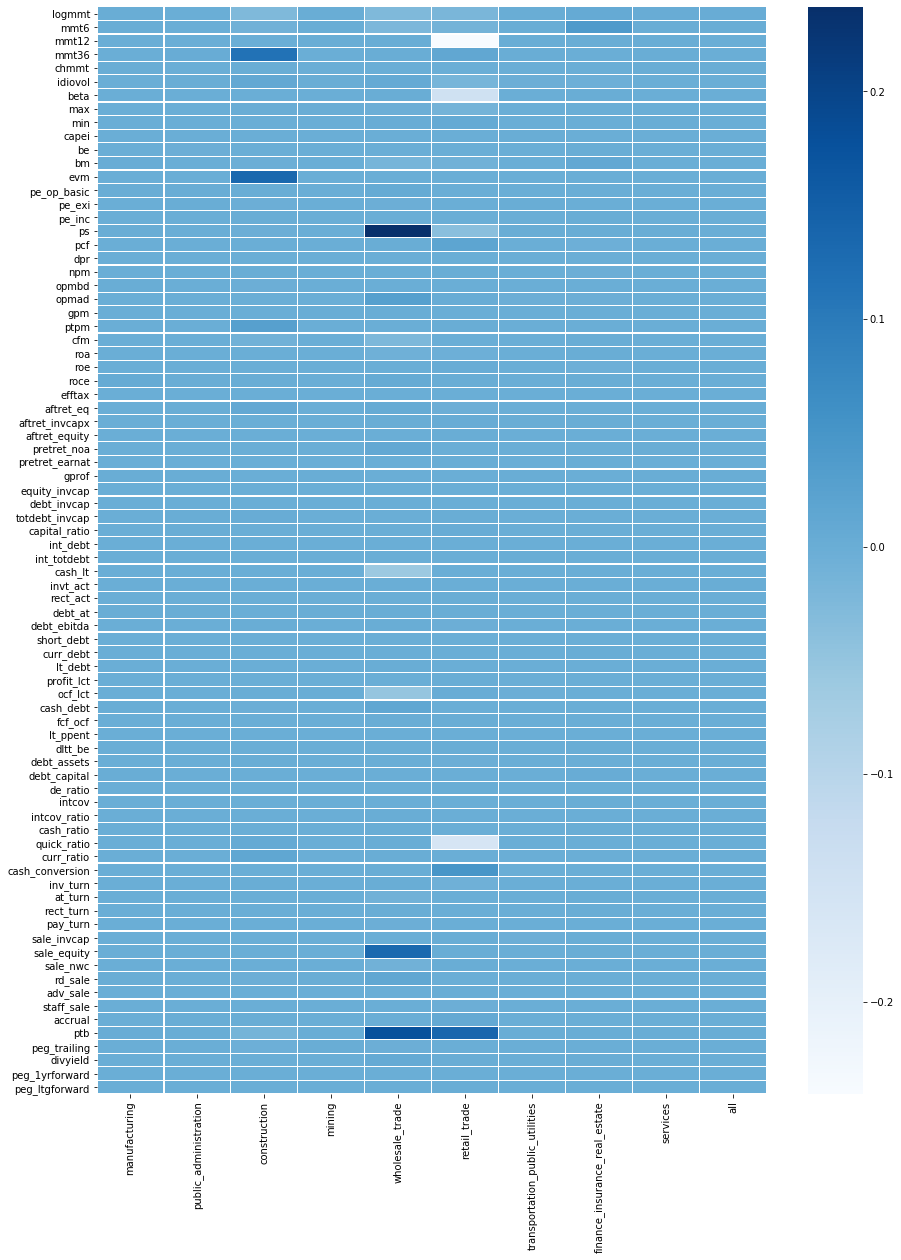

In [103]:
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(GBDT_plot, annot=False, linewidths=0.2, cmap="Blues",ax=ax)

### RF Characteristic Importance for different sectors

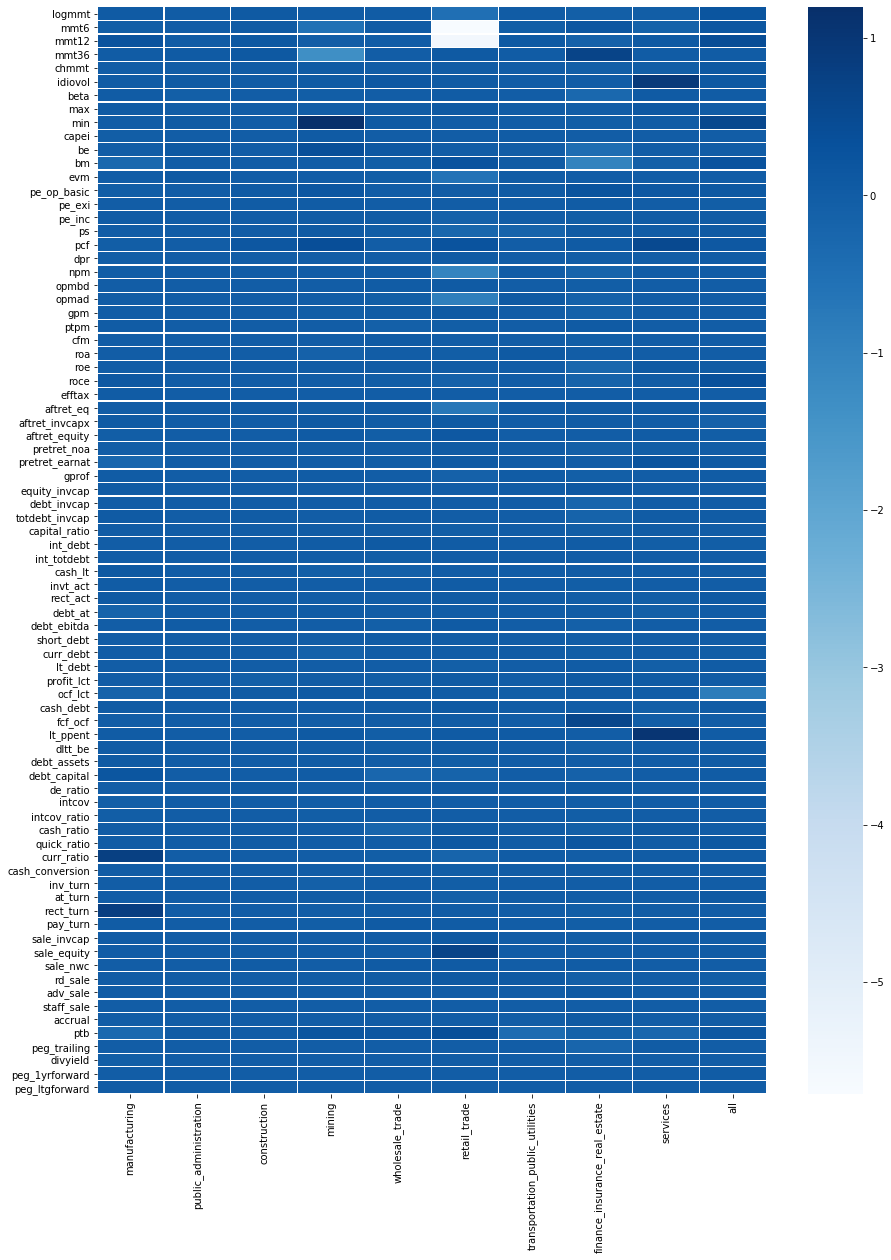

In [104]:
f, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(RF_plot, annot=False, linewidths=0.2, cmap="Blues",ax=ax)

### GBDT Variable Importance by sectors

In [112]:
def importance_plot(features,feature_importance,col):
    #feature_importance = 100.0 * (feature_importance/feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    sorted_feats = []
    for i in sorted_idx:
        sorted_feats.append(features[i])

    pos = np.arange(sorted_idx.shape[0])+.5
    plt.figure(figsize=(20,20))
    plt.barh(pos,feature_importance[sorted_idx],align='center')
    plt.yticks(pos,sorted_feats)
    plt.xlabel('Relative Importance')
    plt.title(col)
    plt.show()
    

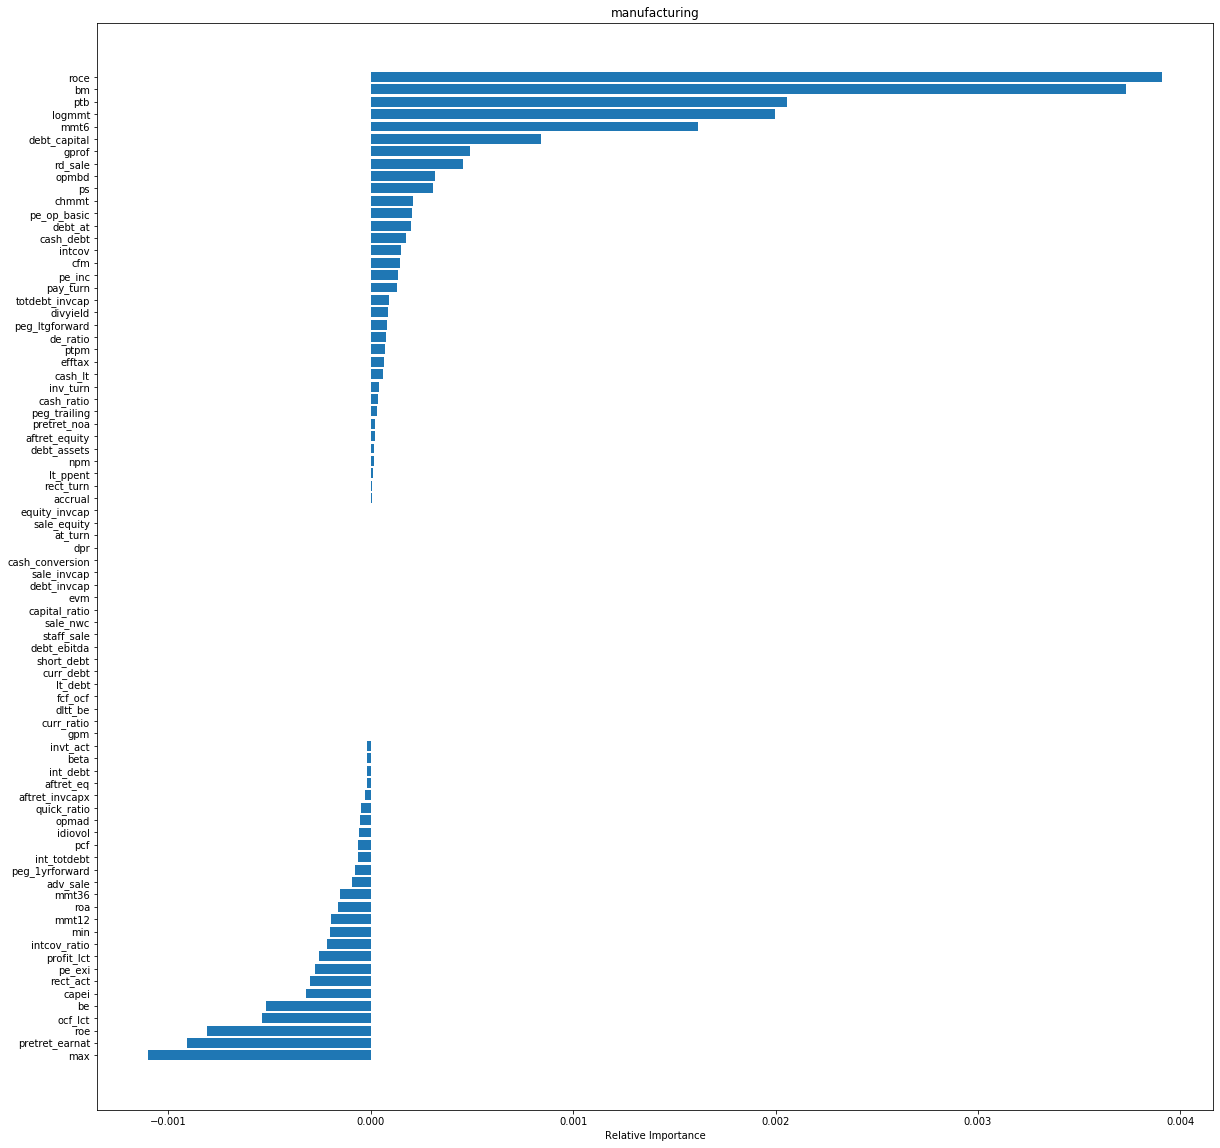

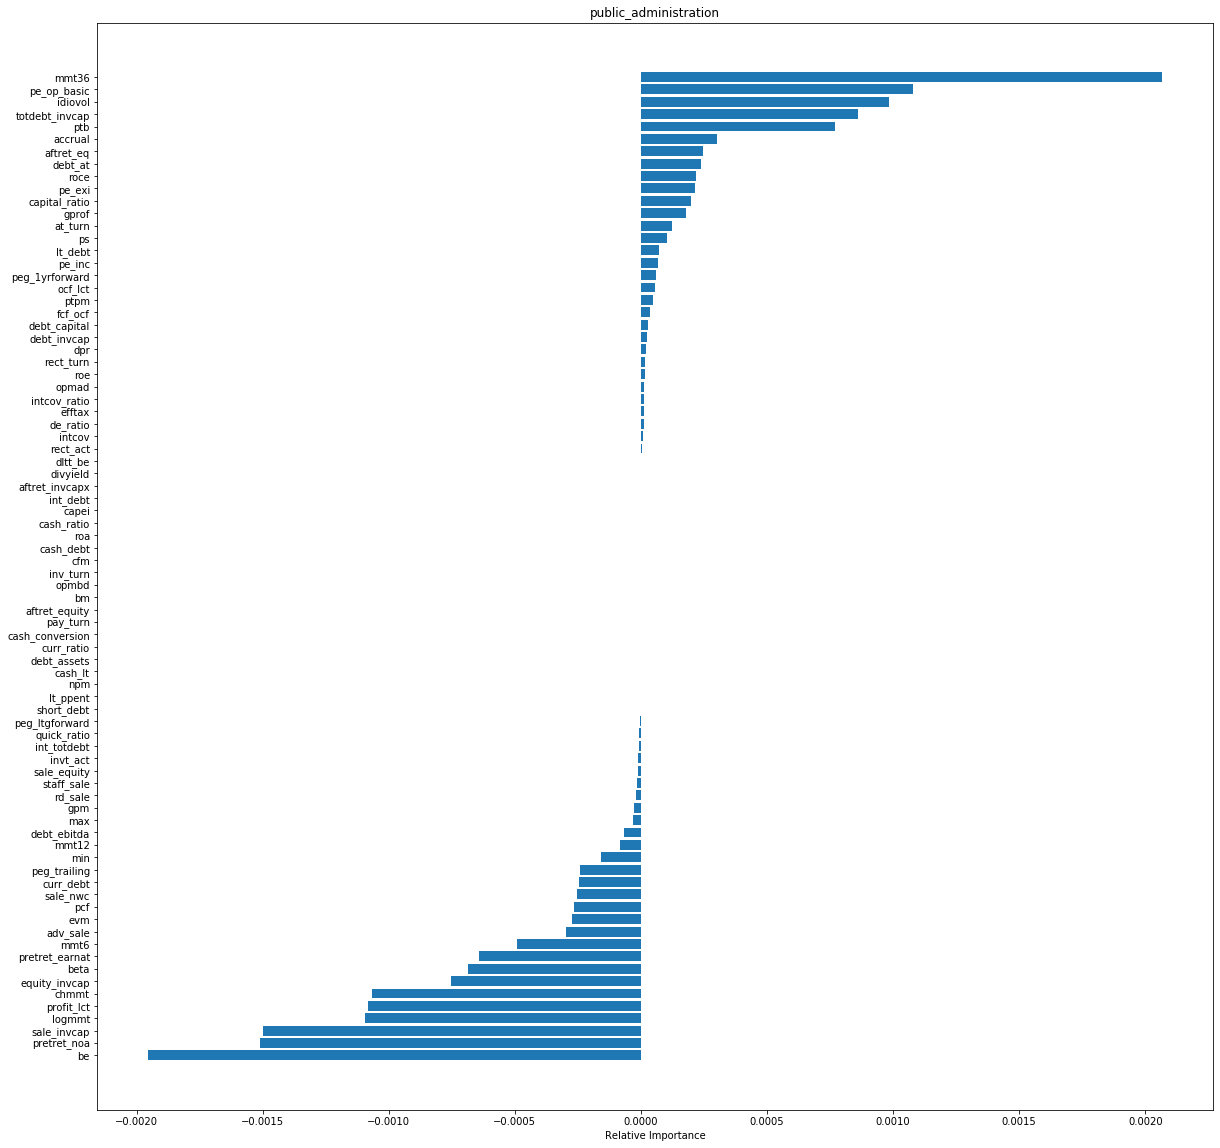

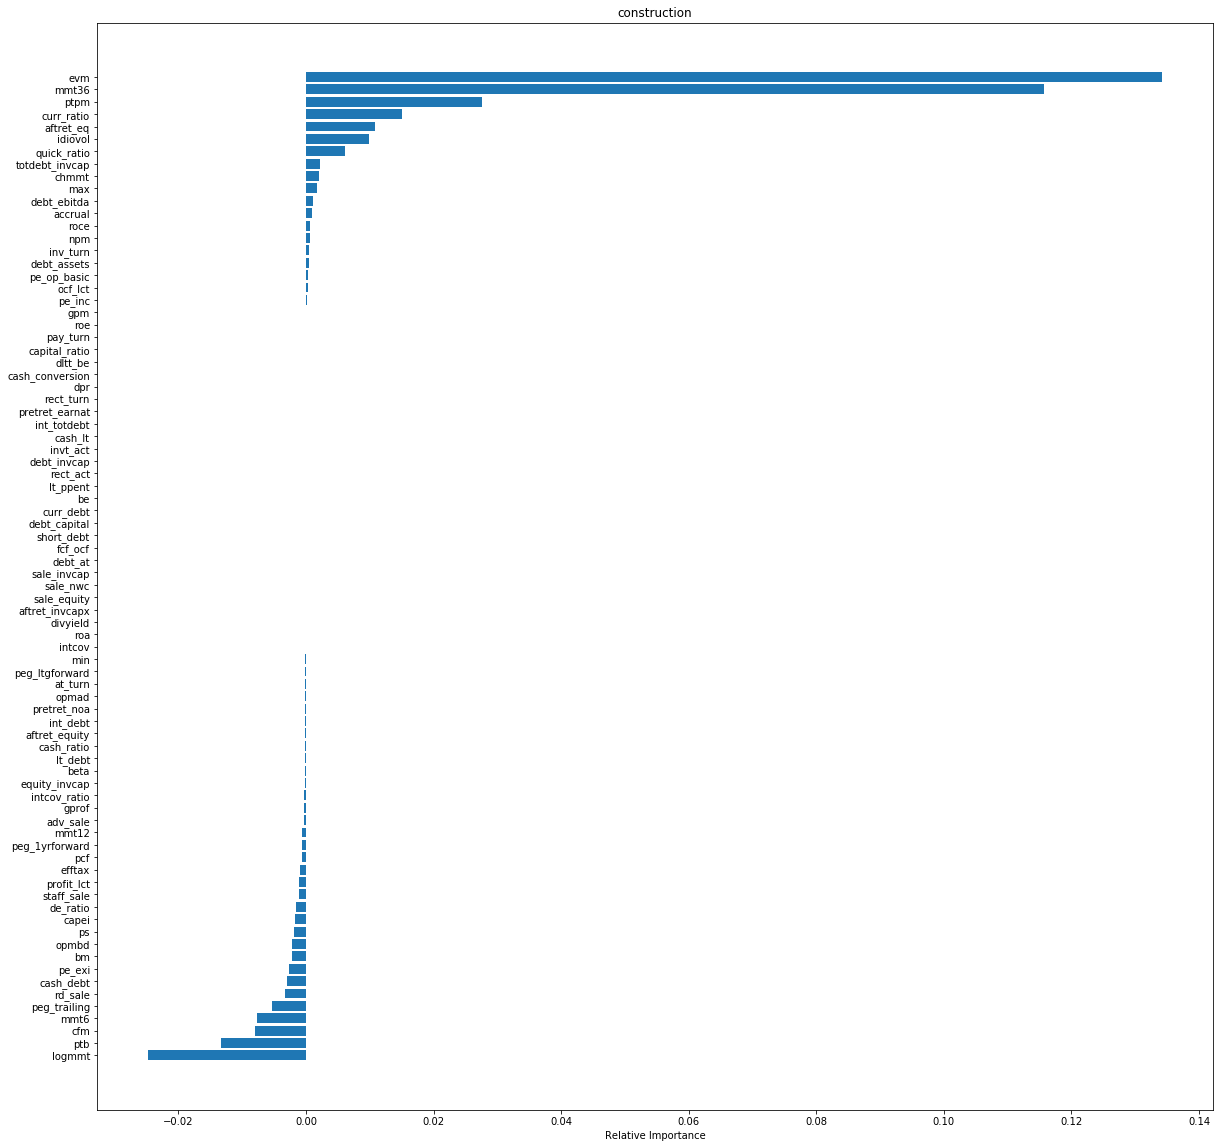

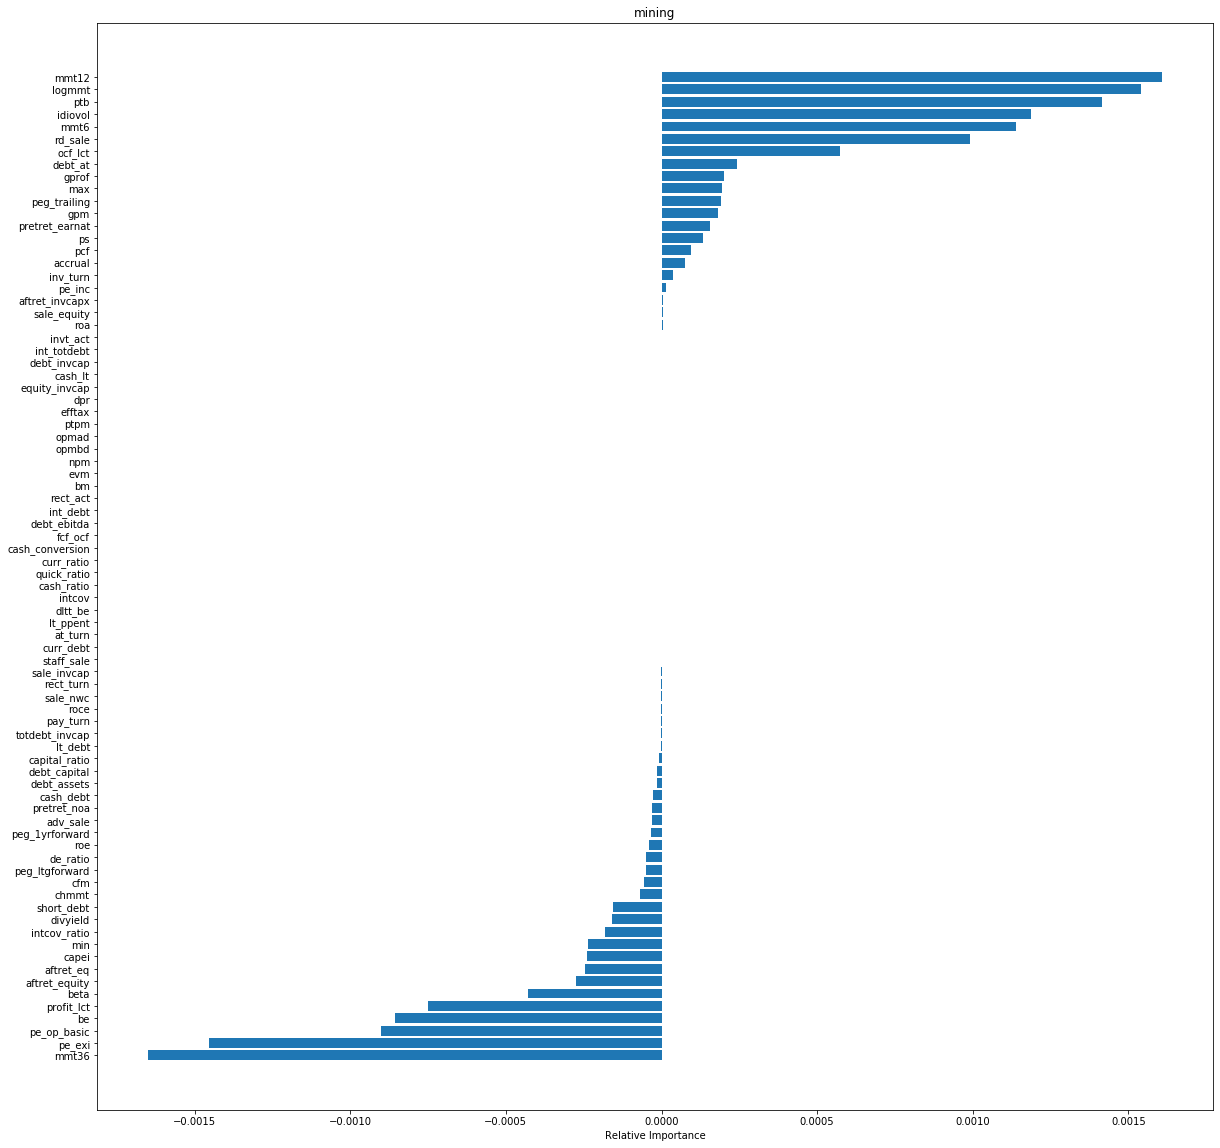

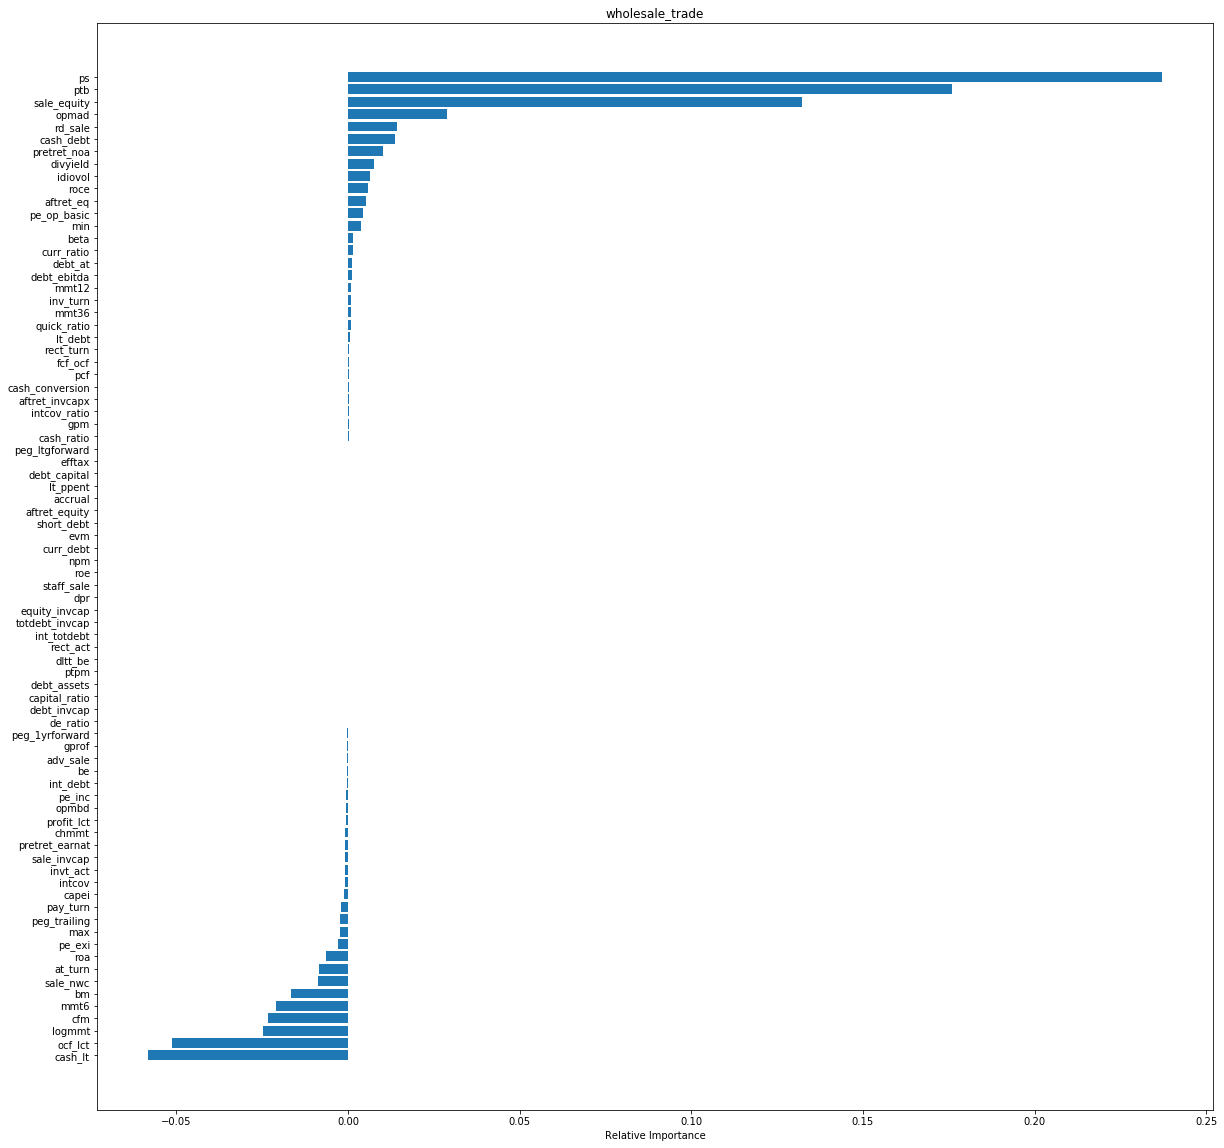

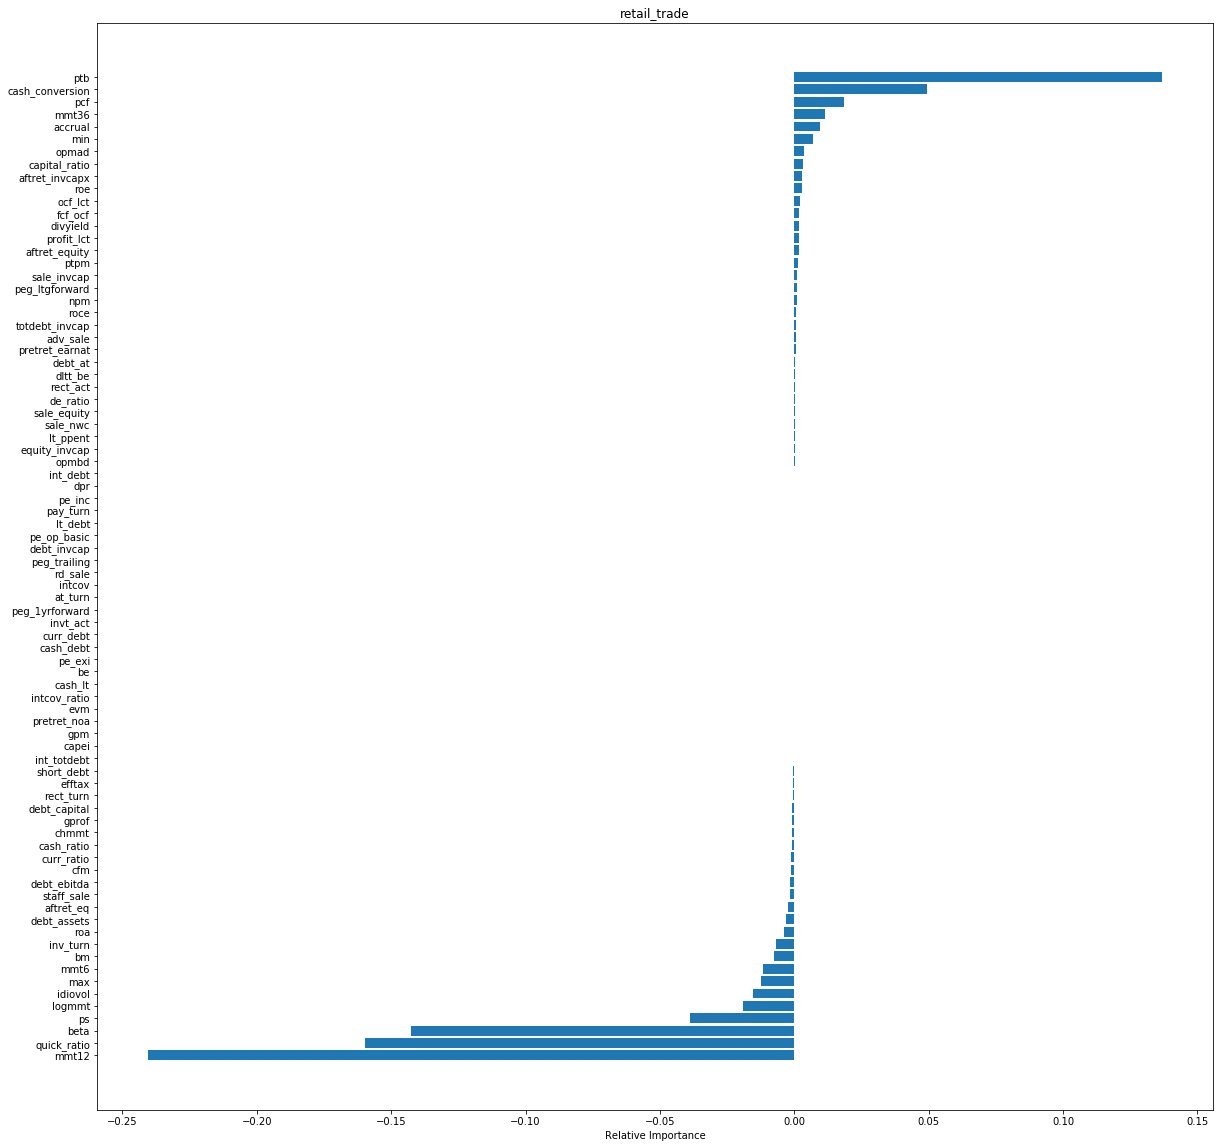

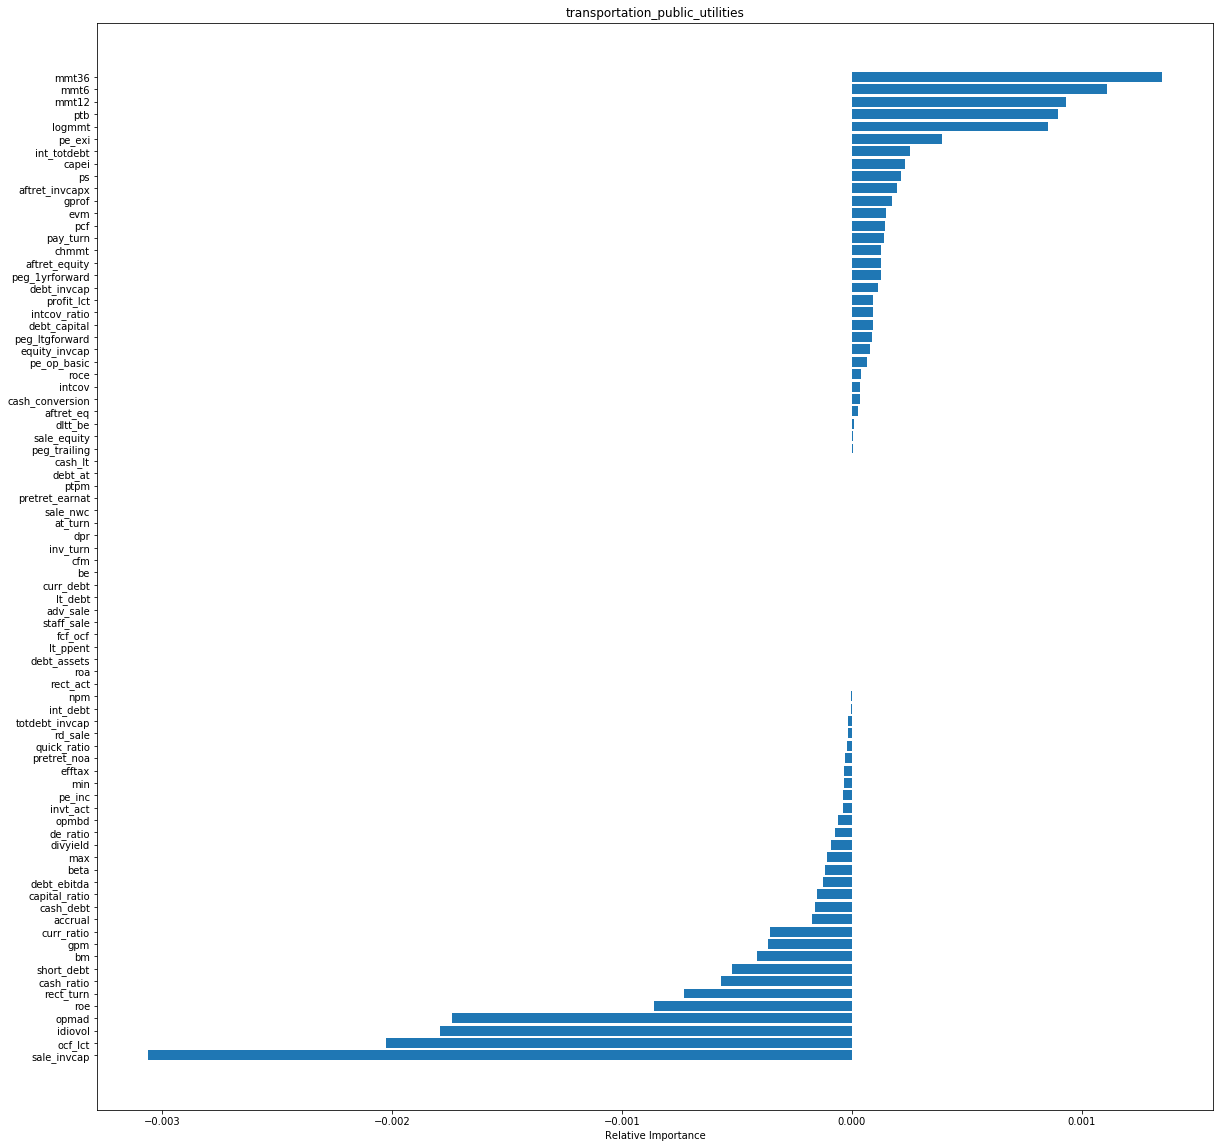

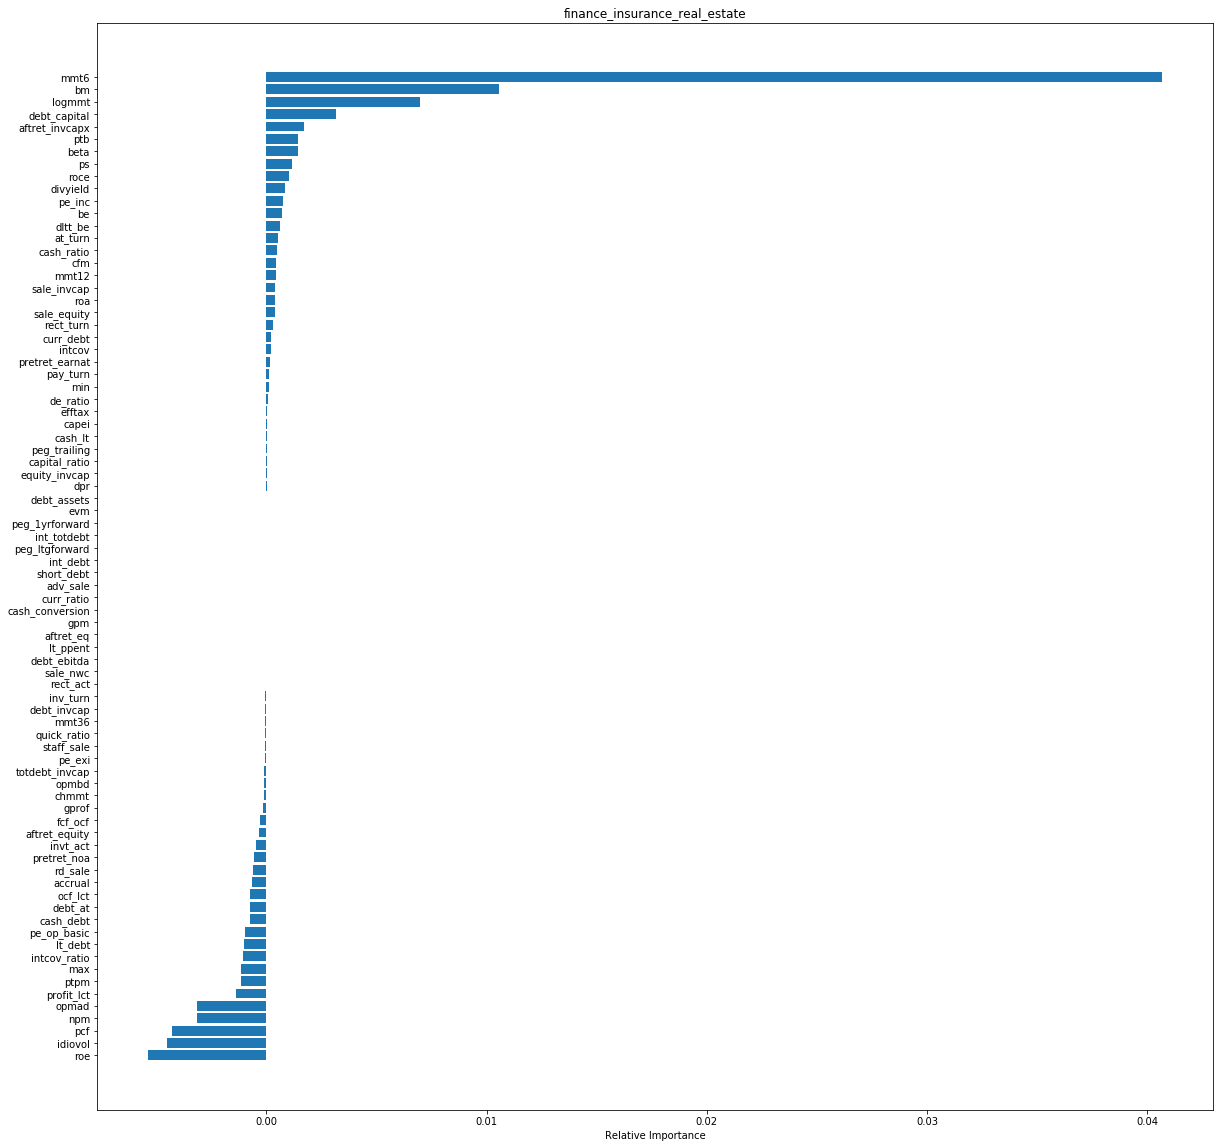

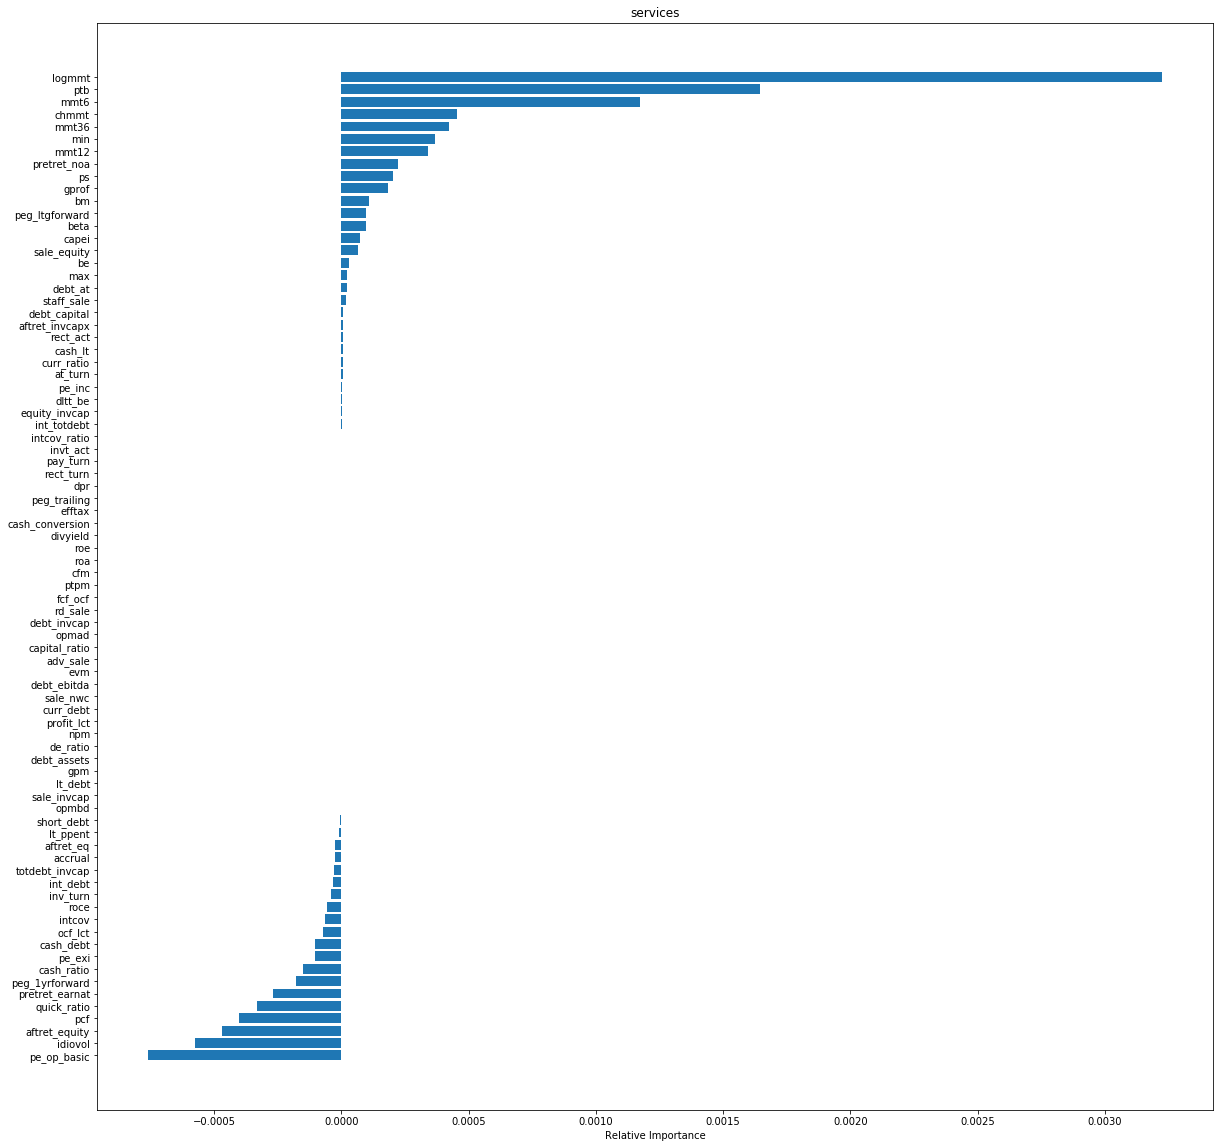

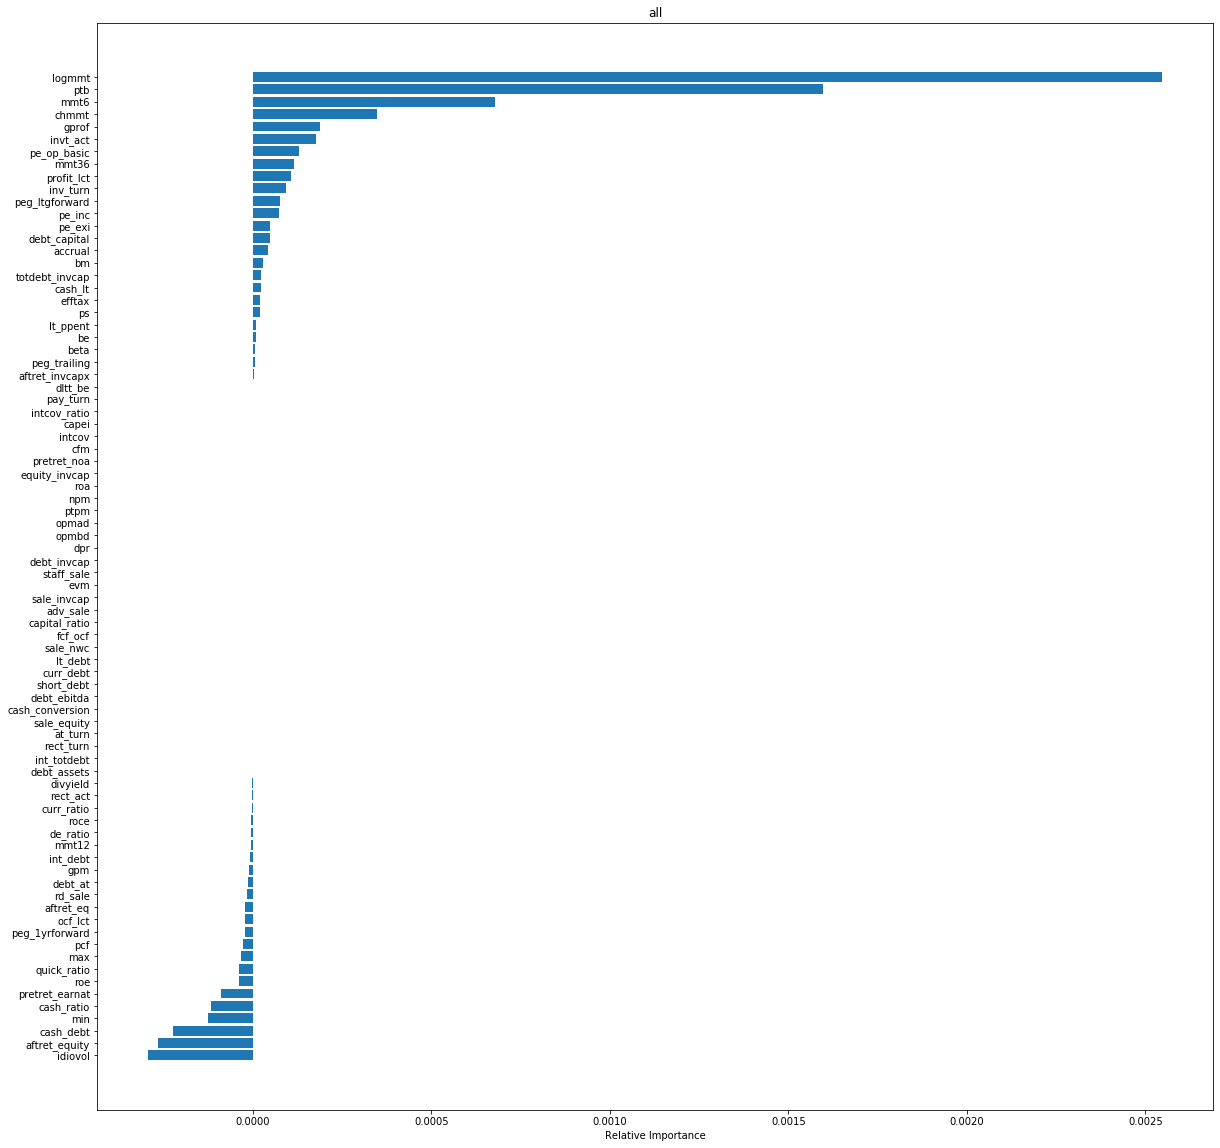

In [113]:
for col in GBDT_plot.columns:
    importance_plot(GBDT_plot.index,GBDT_plot[col],col)

### RF Characteristic Importance for different sectors

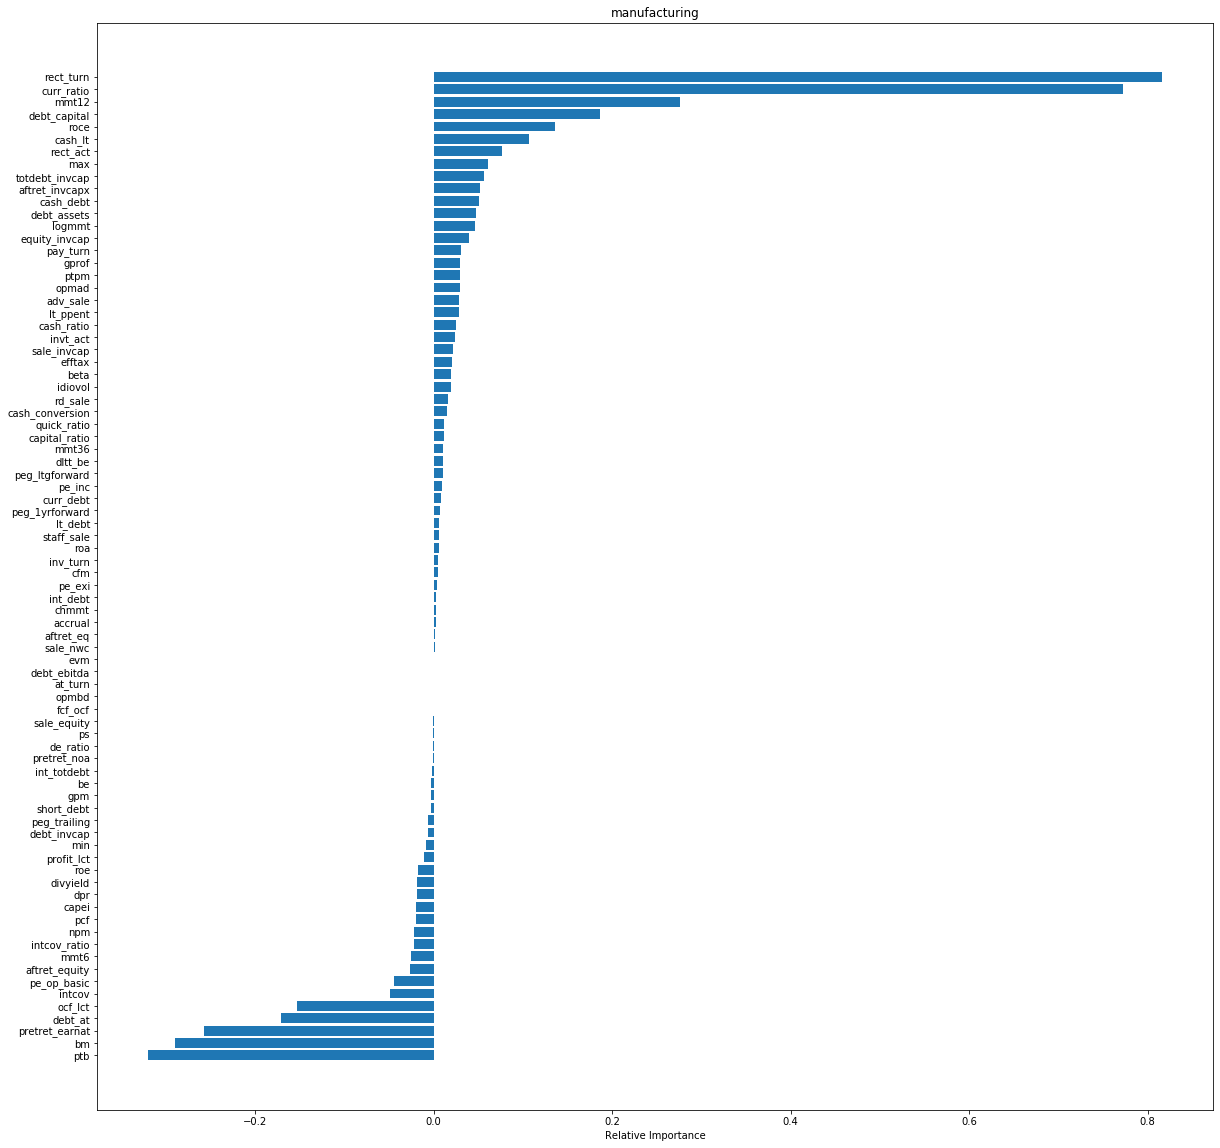

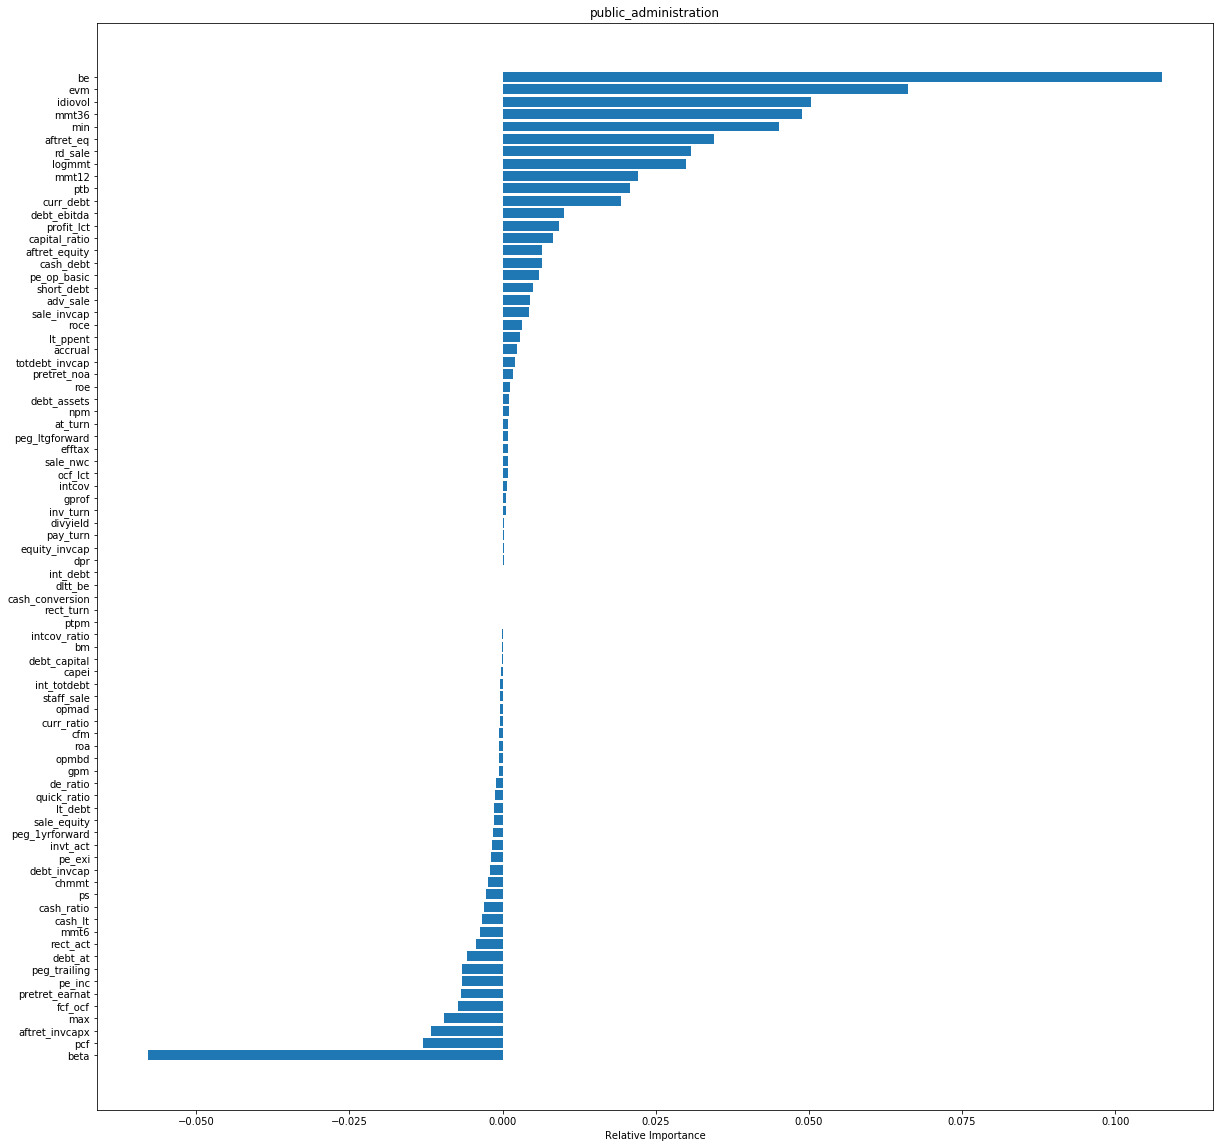

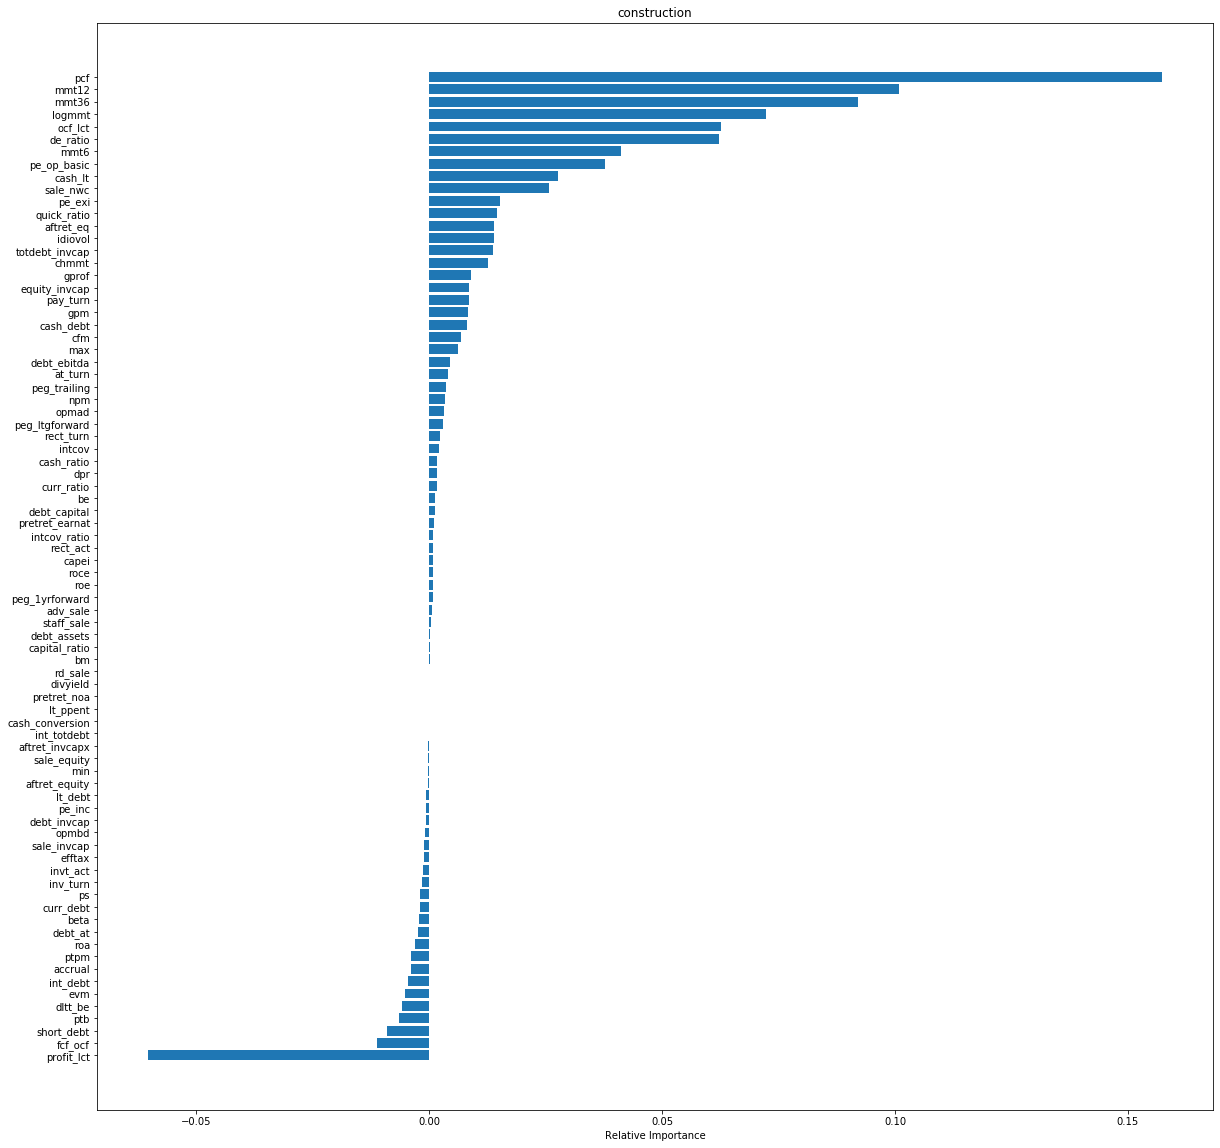

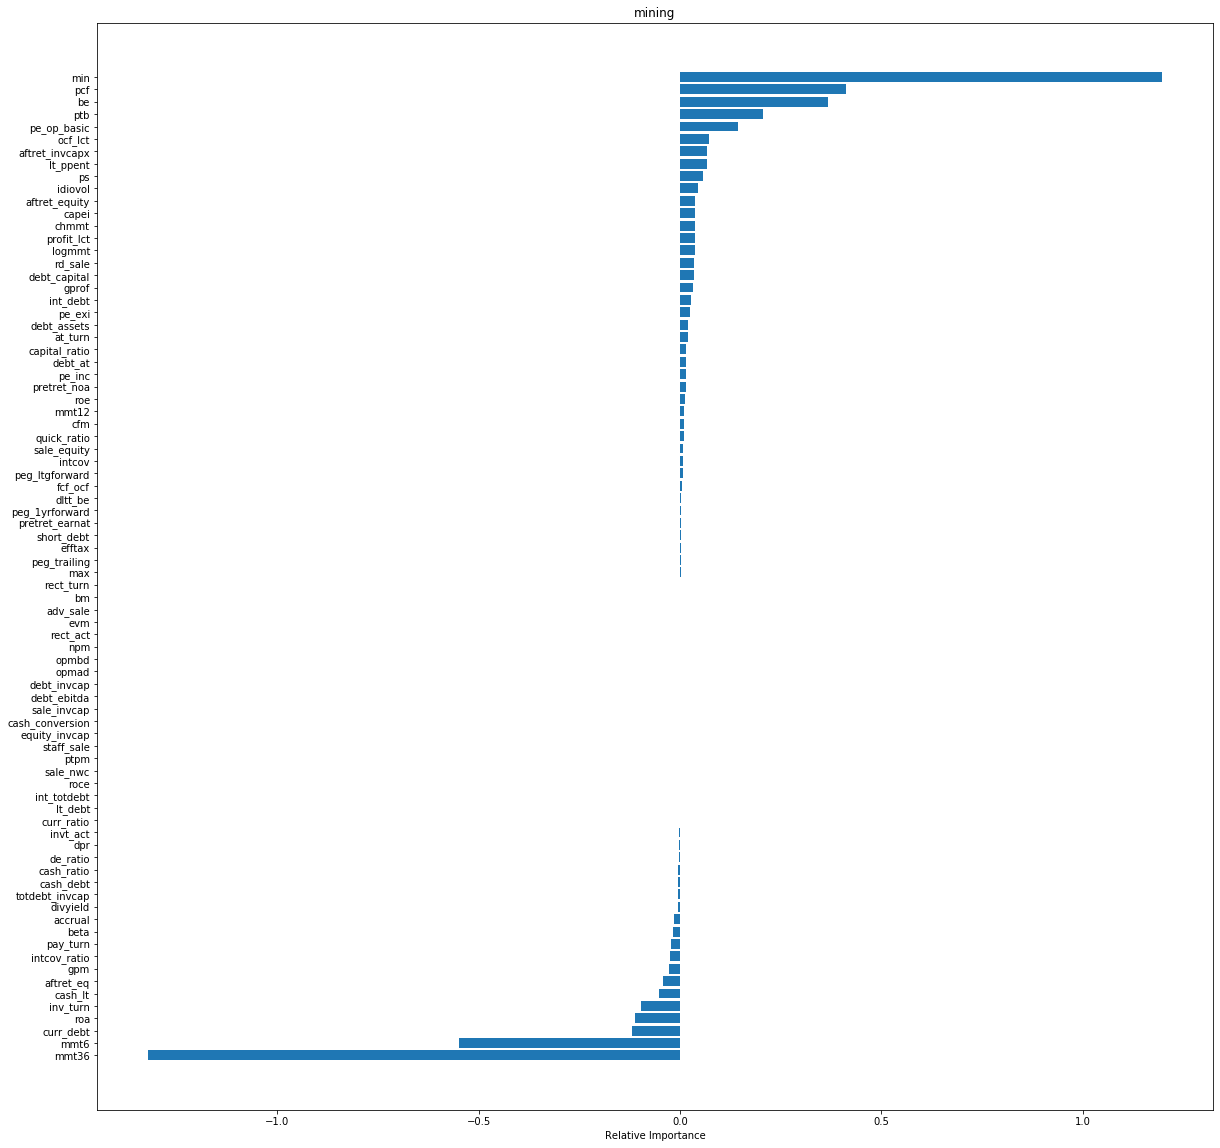

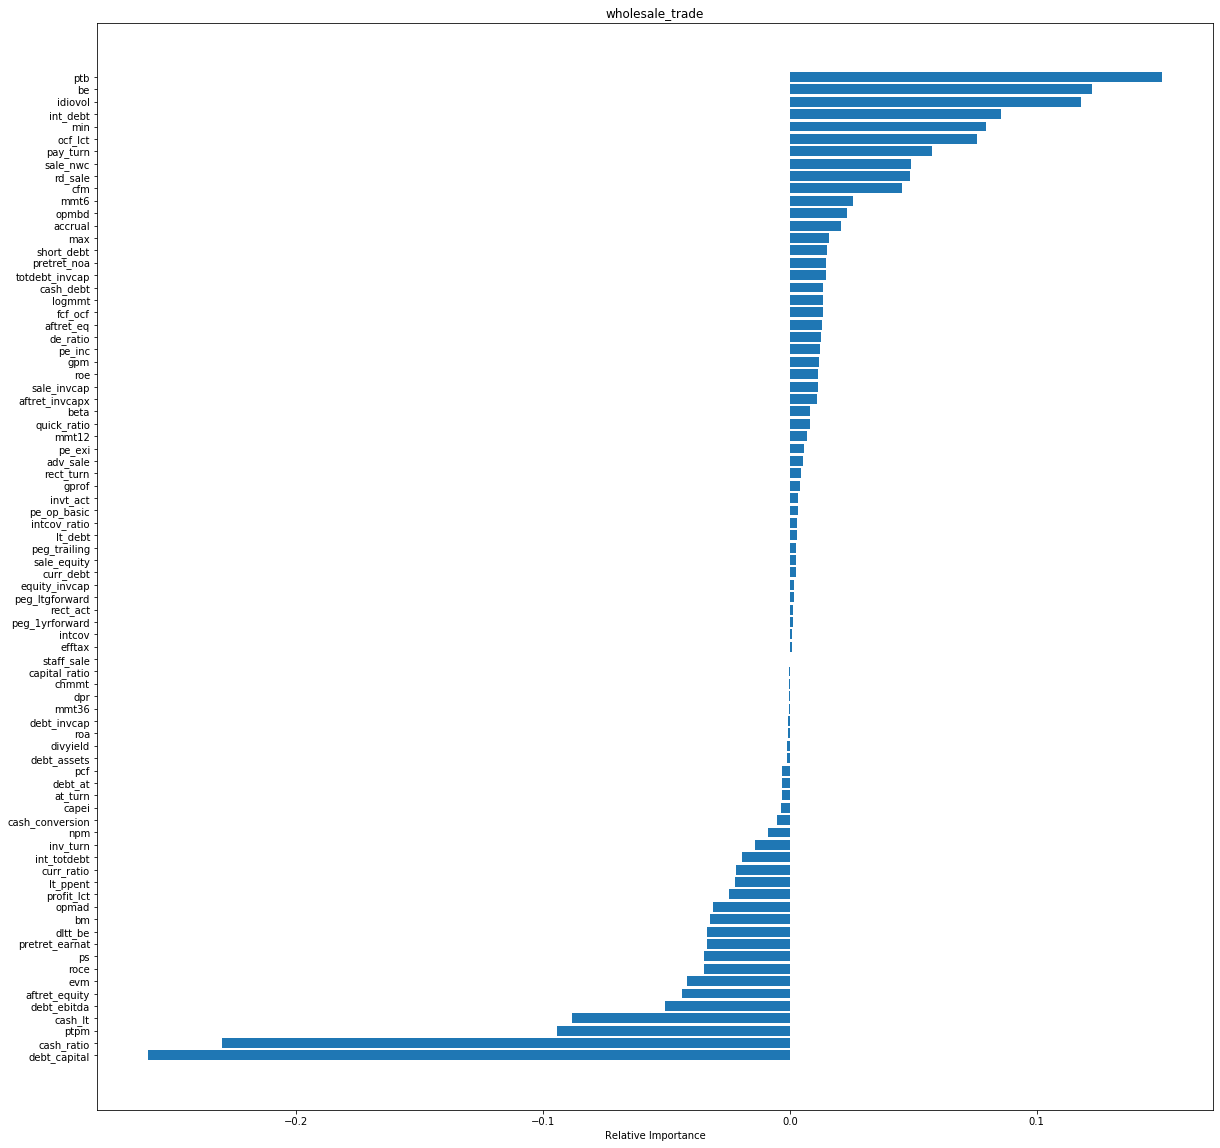

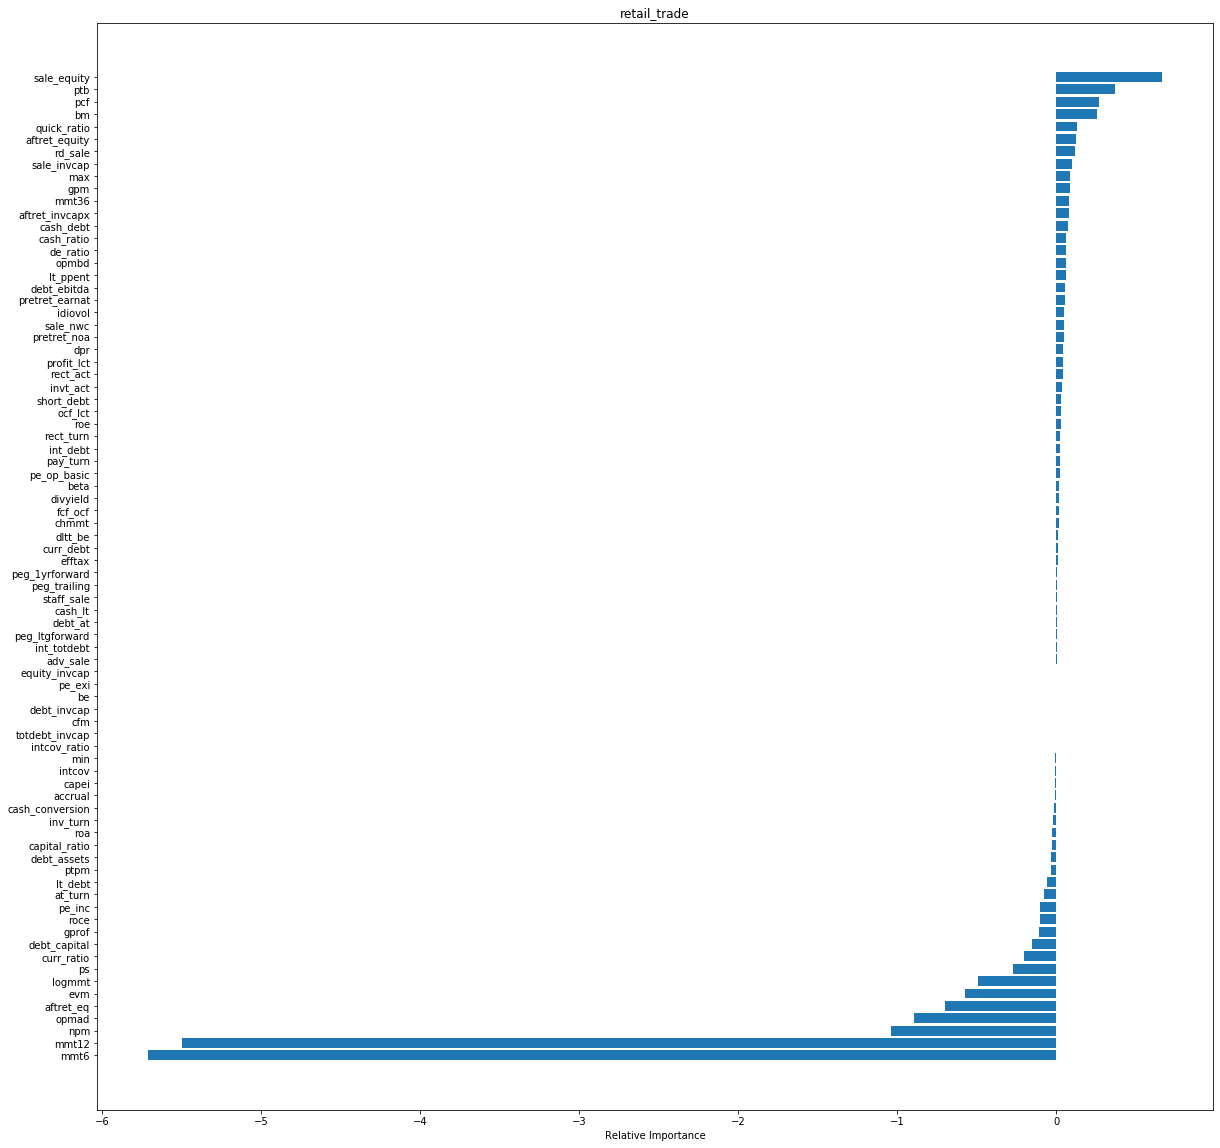

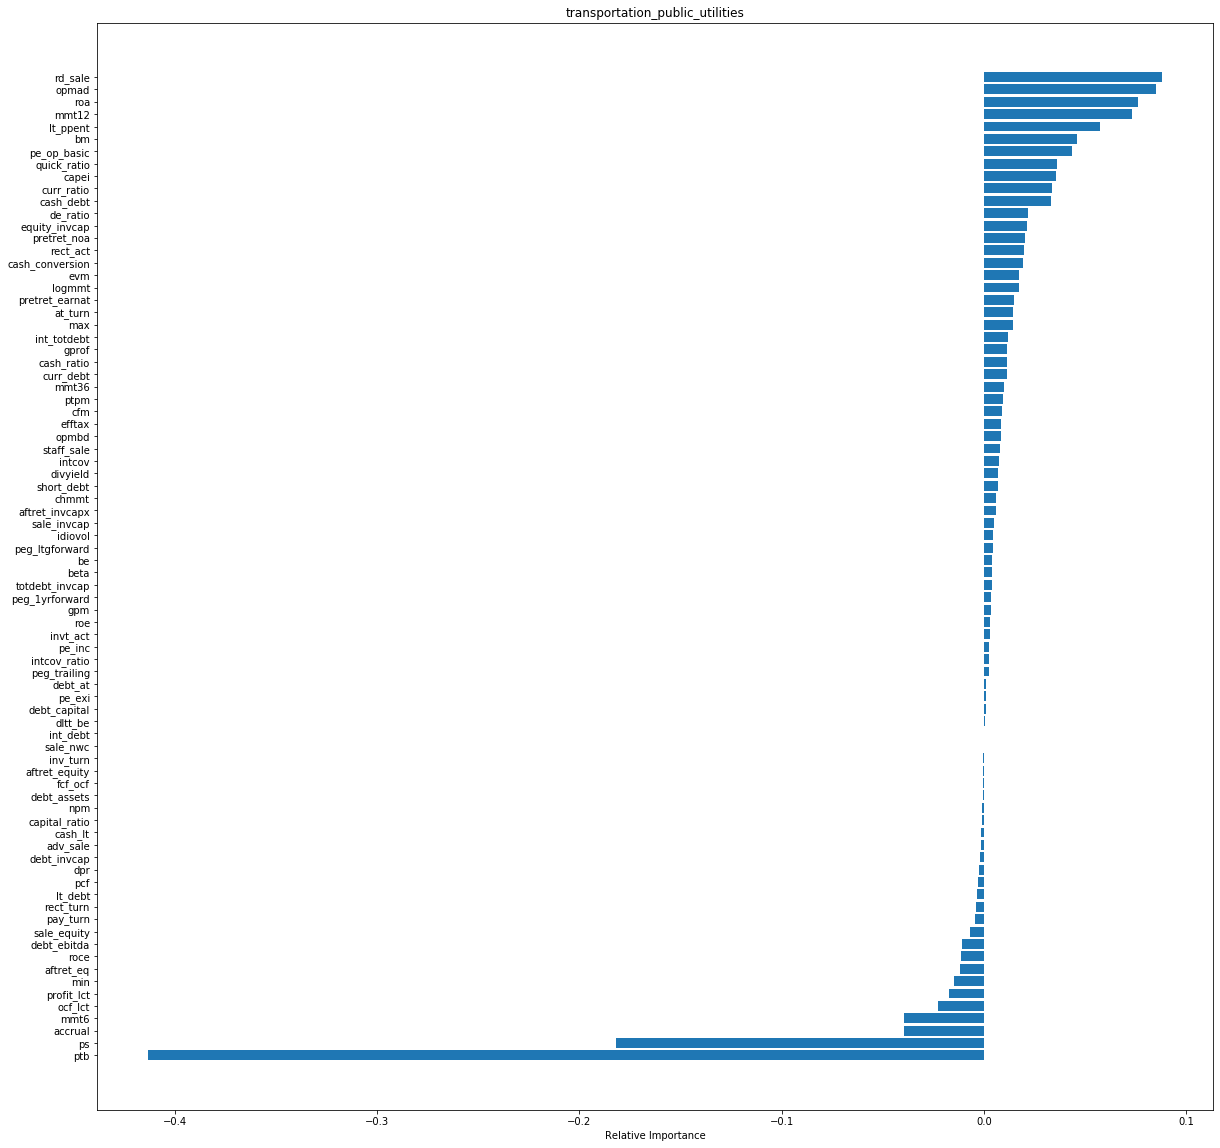

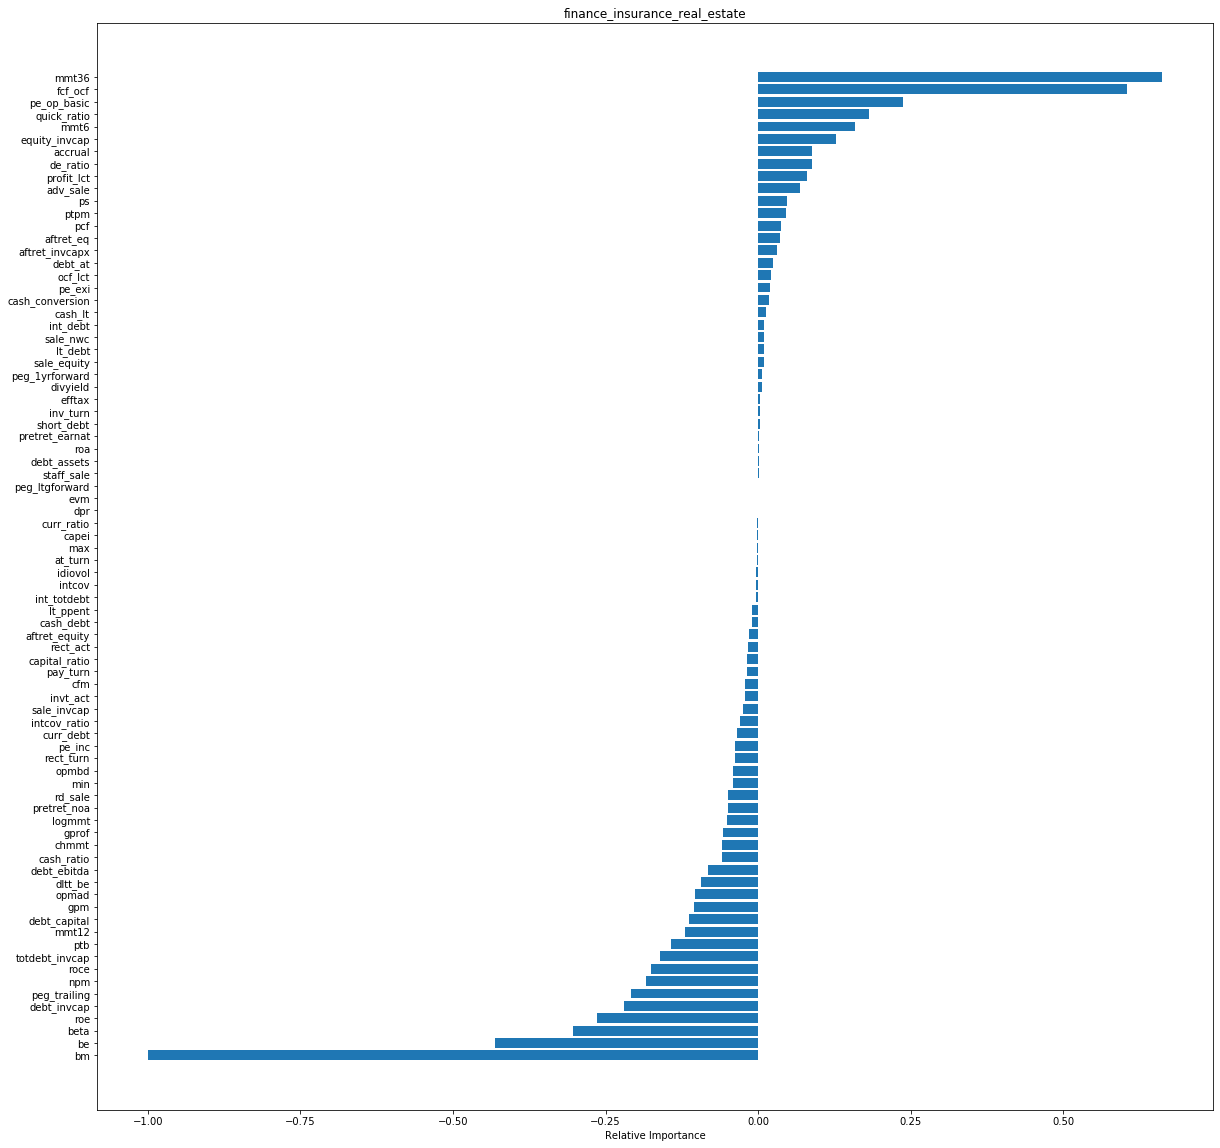

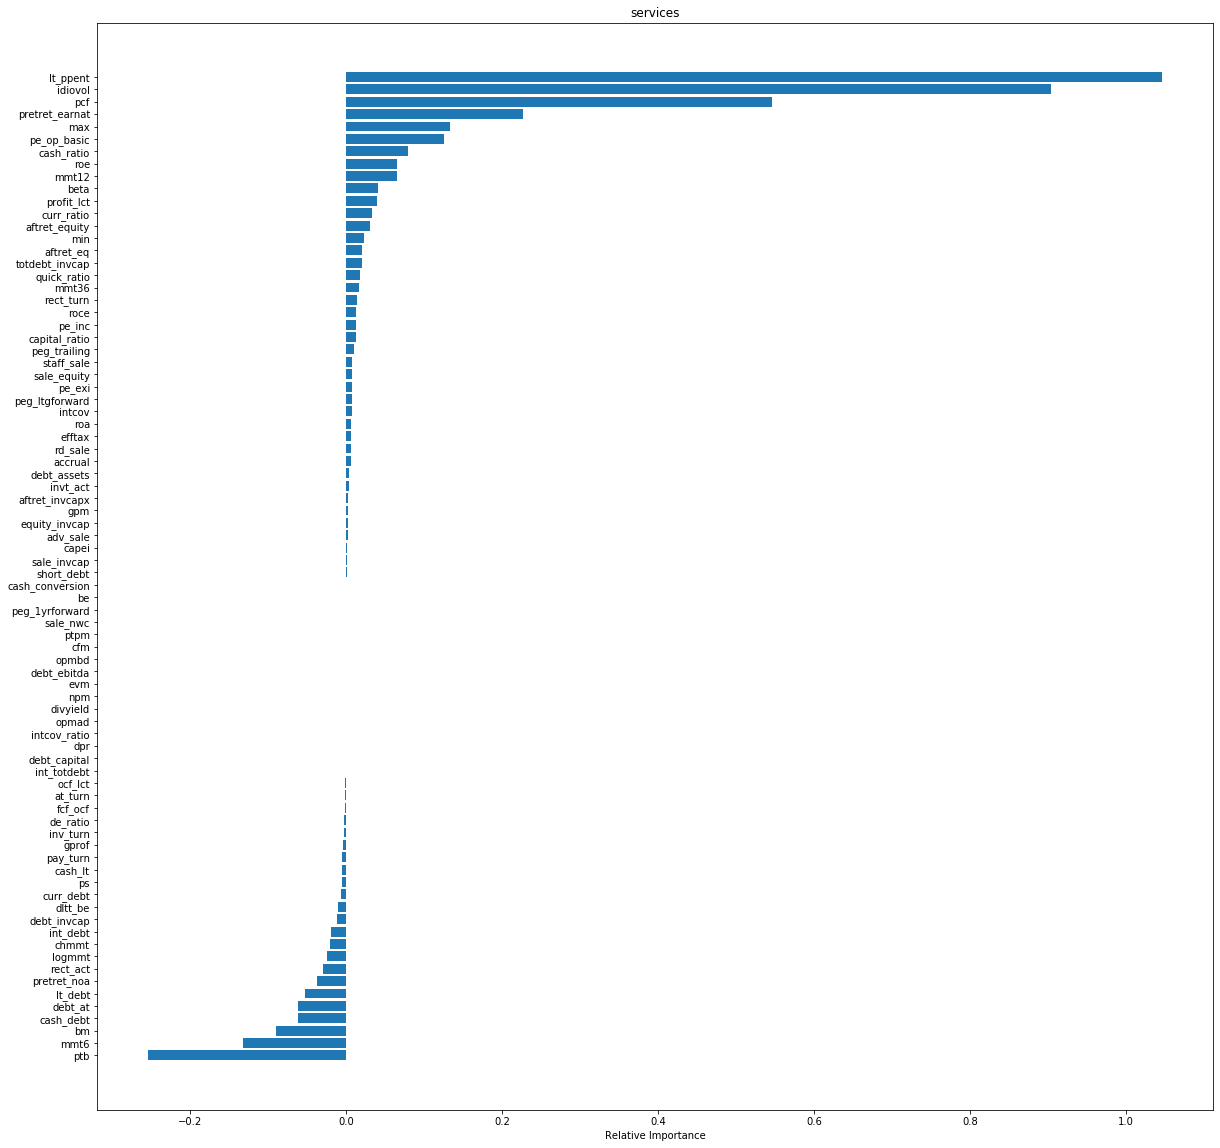

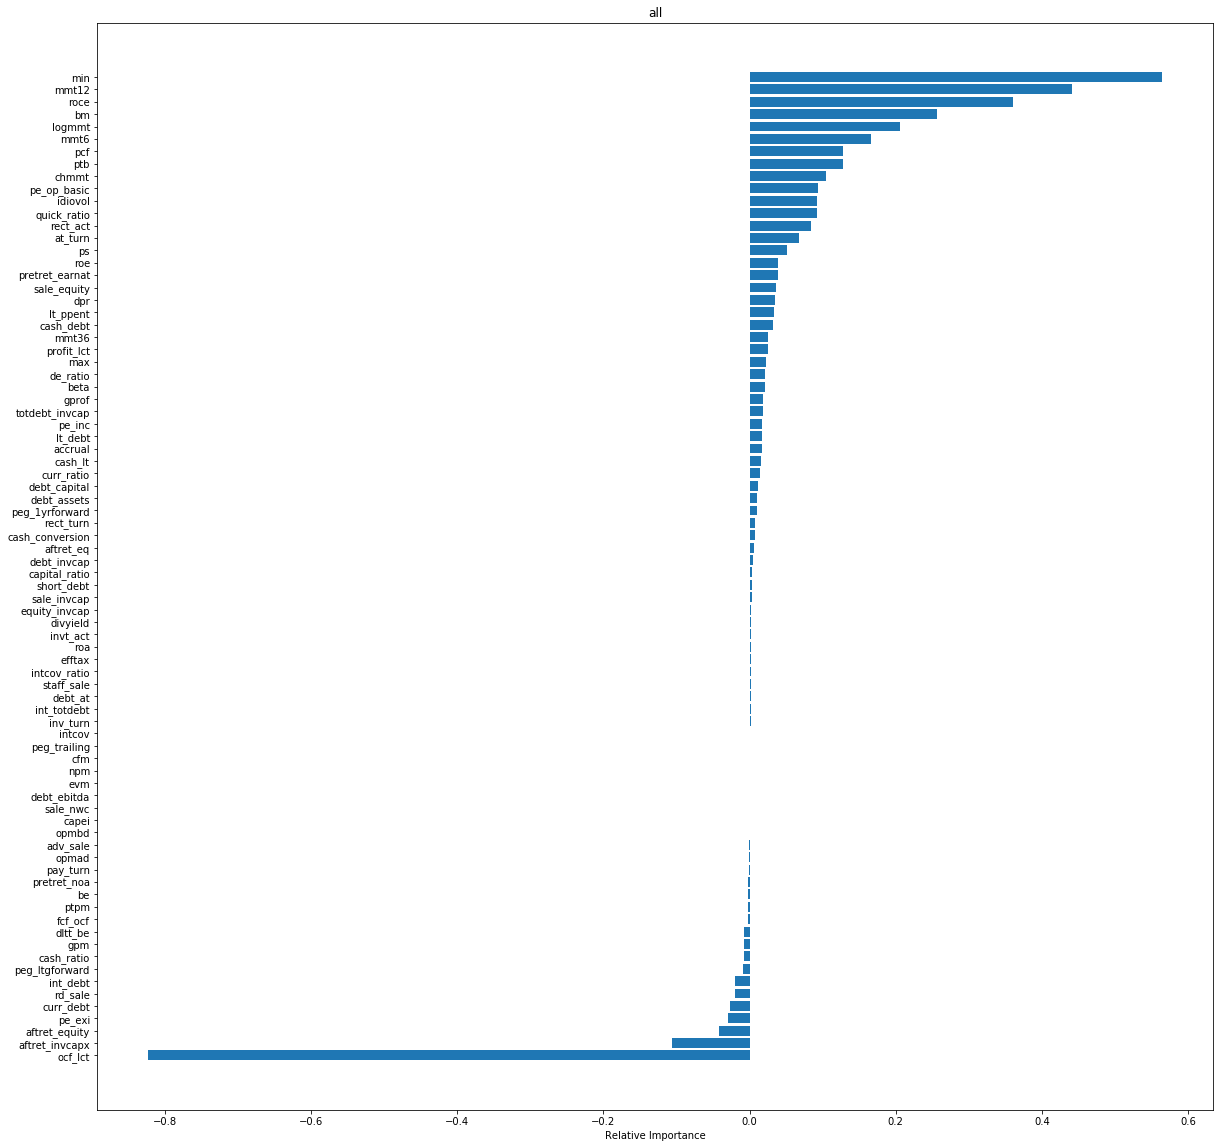

In [114]:
for col in RF_plot.columns:
    importance_plot(RF_plot.index,RF_plot[col],col)

In [ ]:
RF_plot